In [104]:
import os

import astropy.coordinates as coord
coord.galactocentric_frame_defaults.set('v4.0')
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from scipy.special import logsumexp

from pyia import GaiaData
import theano
theano.config.gcc.cxxflags = "-fbracket-depth=16000" # default is 256
import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

pm.__version__

'3.9.2'

Expected mean disk velocity in ICRS:

In [2]:
xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 234, 0])) * u.km/u.s)
vthin = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vlsr = coord.CartesianDifferential(-(np.array([12.9, 245.6, 7.78]) - np.array([0, 200, 0])) * u.km/u.s)
vthik = coord.SkyCoord(xtmp.with_differentials(vlsr), frame='galactic').icrs.velocity.d_xyz.value

xtmp = coord.CartesianRepresentation(100, 0, 0, unit=u.km)
vsun = coord.CartesianDifferential(-np.array([12.9, 245.6, 7.78]) * u.km/u.s)
vhalo = coord.SkyCoord(xtmp.with_differentials(vsun), frame='galactic').icrs.velocity.d_xyz.value

vthin, vthik, vhalo

(array([ 1.72666906, 17.96839664, -5.97107496]),
 array([-15.0730518 ,  33.09260716, -31.36846921]),
 array([-113.89493924,  122.05855141, -180.76490601]))

In [3]:
pc_mas_yr_per_km_s = (1 * u.km/u.s).to(u.pc*u.mas/u.yr, u.dimensionless_angles()).value
km_s_per_pc_mas_yr = 1 / pc_mas_yr_per_km_s

In [4]:
g = GaiaData(os.path.expanduser('~/data/GaiaDR2/rv-good-plx.fits'))

In [5]:
the_og = g[g.source_id == 1490845584382687232]
v0 = the_og.get_skycoord().velocity.d_xyz.value.T[0]
sigma_0 = 0.6  # km/s
v0

array([-6.93189151, 24.30123728, -9.50923957])

How much could the group have dispersed in free space?

In [6]:
(100*u.Myr * 0.6*u.km/u.s).to(u.pc)

<Quantity 61.3627299 pc>

In [7]:
def get_tangent_basis(ra, dec):
    """
    row vectors are the tangent-space basis at (alpha, delta, r)
    ra, dec in radians
    """
    M = np.array([
        [-np.sin(ra), np.cos(ra), 0.],
        [-np.sin(dec)*np.cos(ra), -np.sin(dec)*np.sin(ra), np.cos(dec)],
        [np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)]
    ])
    return M

In [8]:
class UniformSpaceDensity(pm.Continuous):

    def __init__(self, rlim, **kwargs):
        """A uniform space density prior over a distance, r, between (0, rlim)
        """

        self.rlim = float(rlim)
        assert (self.rlim > 0)
        self._fac = np.log(3.) - 3 * np.log(self.rlim)

        shape = kwargs.get("shape", None)
        if shape is None:
            testval = 0.5 * self.rlim
        else:
            testval = 0.5 * self.rlim + np.zeros(shape)
        kwargs["testval"] = kwargs.pop("testval", testval)
        super(UniformSpaceDensity, self).__init__(**kwargs)

    def _random(self, size=None):
        uu = np.random.uniform(size=size)
        return np.cbrt(uu) * self.rlim

    def random(self, point=None, size=None):
        return generate_samples(
            self._random,
            dist_shape=self.shape,
            broadcast_shape=self.shape,
            size=size,
        )

    def logp(self, value):
        return 2 * tt.log(tt.as_tensor_variable(value)) + self._fac

In [80]:
filename = '../data/all_stars_near_theOG.csv'
if os.path.exists(filename):
    prev = at.Table.read(filename, format='ascii.ecsv')
else:
    prev = None # For first run

In [82]:
c = g.get_skycoord()
the_og_c = the_og.get_skycoord()[0]

sep3d_mask = c.separation_3d(the_og_c) < 70*u.pc
vel3d_mask = (c.velocity - the_og_c.velocity).norm() < 15*u.km/u.s
xv_mask = vel3d_mask & sep3d_mask

subg = g[xv_mask]

if prev is not None:
    not_prev_mask = ~np.isin(subg.source_id, prev['source_id'])
    subg = subg[not_prev_mask]

sep3d_mask.sum(), vel3d_mask.sum(), xv_mask.sum(), len(subg)

(26887, 302969, 2767, 961)

In [83]:
Cs = subg.get_cov(units=dict(pmra=u.mas/u.yr, pmdec=u.mas/u.yr, radial_velocity=u.km/u.s))
C = Cs[:, 2:, 2:]

In [84]:
N = len(subg)

ra = subg.ra.to_value(u.rad)
dec = subg.dec.to_value(u.rad)
M = np.stack([get_tangent_basis(ra[i], dec[i]) for i in range(N)])
y = np.stack([subg.parallax.value, 
              subg.pmra.value, 
              subg.pmdec.value, 
              subg.radial_velocity.value], 
             axis=1)

Cinvs = np.stack([np.linalg.inv(C[n]) for n in range(N)], axis=0)

C.shape, M.shape, y.shape

((961, 4, 4), (961, 3, 3), (961, 4))

16.14998308012067 -1.5587678391681004
33.681902747385706 18.607217802793844
20.12456579753809 -10.26107439934088


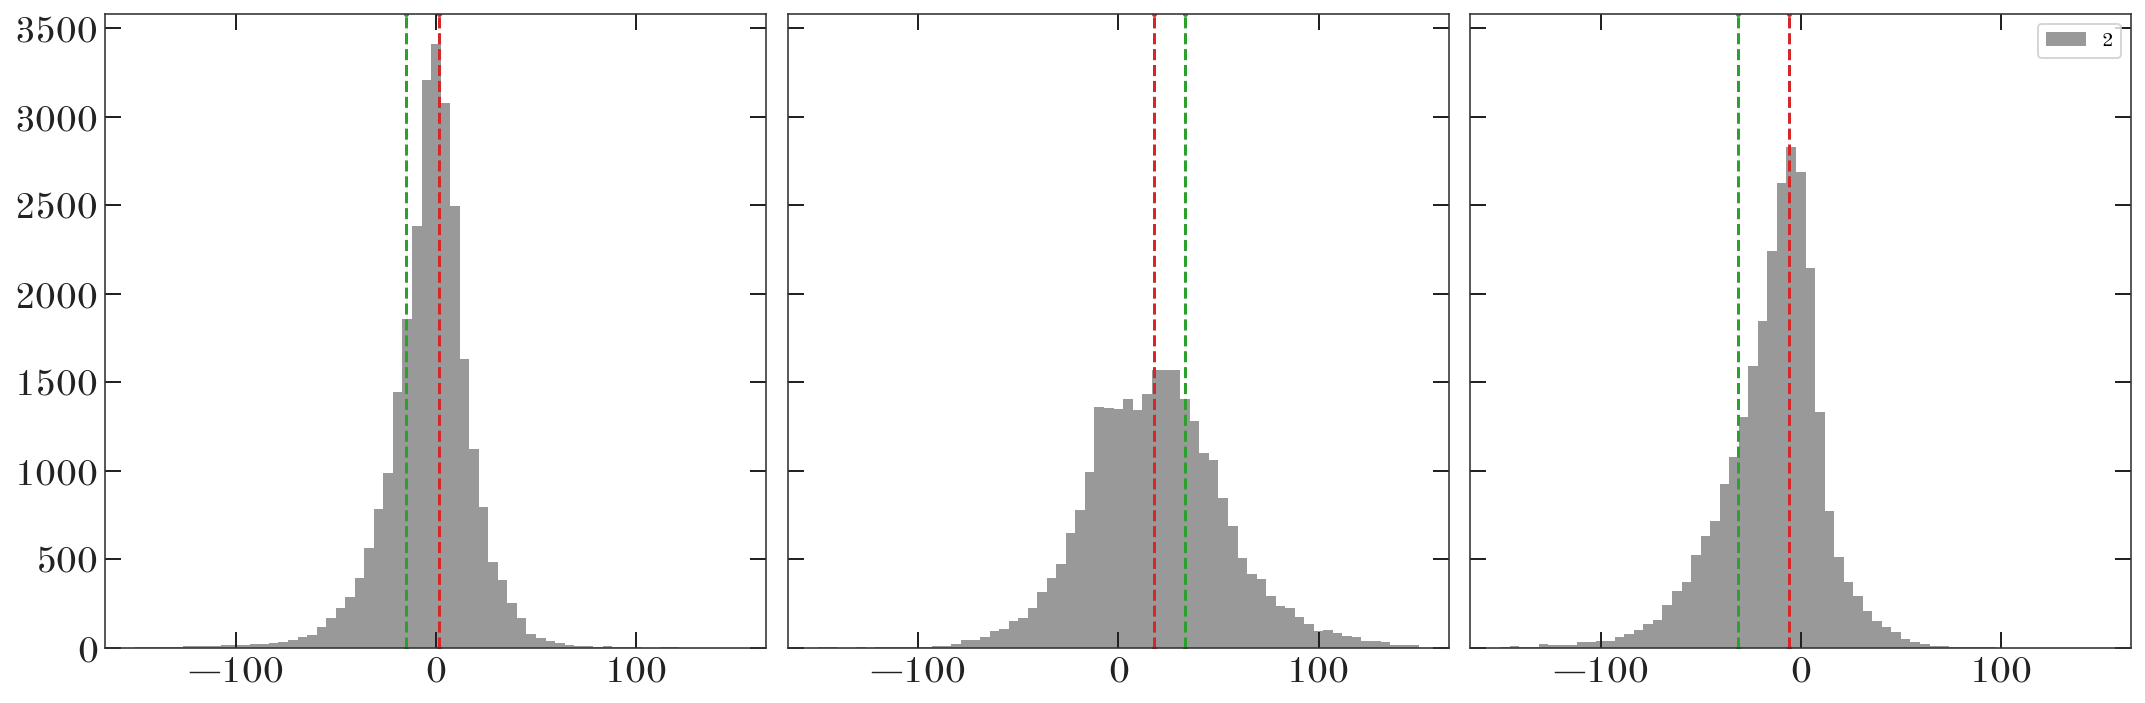

In [85]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
for i in range(3):
    ax = axes[i]
    
    _x = g[sep3d_mask].get_skycoord().velocity.d_xyz.value[i]
    print(1.5 * np.median(np.abs(_x - np.median(_x))),
          np.median(_x))
    ax.hist(g[sep3d_mask].get_skycoord().velocity.d_xyz.value[i],
            bins=np.linspace(-150, 150, 64), alpha=0.4, label=str(i));
    
    ax.axvline(vthin[i], color='tab:red', linestyle='--')
    ax.axvline(vthik[i], color='tab:green', linestyle='--')
    
ax.legend(loc='best')

fig.tight_layout()

In [86]:
test_vxyz = subg.get_skycoord().velocity.d_xyz.value.T
test_d = subg.distance.value

In [87]:
sigma_thin = 20.  # np.array([15, 35, 20.])
sigma_thik = 50.
sigma_halo = 125.  # np.full(3, 125.)  # km/s

# Number of prior mixture components:
K = 4
with pm.Model() as model:
    r = UniformSpaceDensity("r", 2000, shape=N, testval=test_d)
    
    # Mixture model for 3D velocity
    w = pm.Dirichlet('w', a=np.ones(K))
    
    _v0 = pm.Normal.dist(v0, np.full(3, sigma_0), 
                         shape=(N, 3))
    _v1 = pm.Normal.dist(vthin, sigma_thin, 
                         shape=(N, 3))
    _v2 = pm.Normal.dist(vthik, sigma_thik, 
                         shape=(N, 3))
    _v3 = pm.Normal.dist(vhalo, sigma_halo, 
                         shape=(N, 3))
    vxyz = pm.Mixture('vxyz', w=w, comp_dists=[_v0, _v1, _v2, _v3], 
                      testval=test_vxyz, shape=(N, 3)) 
    
    v0_logp = pm.Deterministic('v0_logp', _v0.logp(vxyz))
    v1_logp = pm.Deterministic('v1_logp', _v1.logp(vxyz))
    v2_logp = pm.Deterministic('v2_logp', _v2.logp(vxyz))
    v3_logp = pm.Deterministic('v3_logp', _v3.logp(vxyz))
    
    # Velocity in tangent plane coordinates
    vtan = tt.batched_dot(M, vxyz)
    
    model_pm = vtan[:, :2] / r[:, None] * pc_mas_yr_per_km_s
    model_rv = vtan[:, 2:3]
    model_y = tt.concatenate((1000 / r[:, None], model_pm, model_rv), axis=1)
    
    # Option 1:
    # for n in range(N):
    #     pm.MvNormal(f'y{n}', mu=model_y[n], cov=C[n], observed=y[n], shape=4)
    
    # Option 2:
#     val = tt.as_tensor_variable(0.)
#     for n in range(N):
#         # val += pm.MvNormal.dist.logp(mu=model_y[n], cov=C[n], observed=y[n], shape=4)
#         dy = model_y[n] - y[n]
#         val += -0.5 * tt.transpose(dy).dot(Cinvs[n]).dot(dy)

    # Option 3:
    dy = model_y - y
    val = -0.5 * tt.batched_dot(dy, tt.batched_dot(Cinvs, dy))

    pm.Potential("more_logp", val)

In [88]:
with model:
    res = xo.optimize(start={'w': np.ones(K), 
                             'r': test_d,
                             'vxyz': test_vxyz})

optimizing logp for variables: [vxyz, w, r]


message: Desired error not necessarily achieved due to precision loss.
logp: -25953.312594075727 -> -24041.686508833318


In [94]:
# res['r'] / test_d

In [95]:
logps = np.zeros((N, K))
for k in range(K):
    logps[:, k] = res[f'v{k}_logp'].sum(axis=1)

In [96]:
# for i in range(3):
#     _x = test_vxyz[:, i]
#     print(1.5 * np.median(np.abs(_x - np.median(_x))),
#           np.median(_x))
#     plt.hist(test_vxyz[:, i],
#              bins=np.linspace(-100, 100, 64), alpha=0.4, label=str(i),
#              density=True);
    
#     _grid = np.linspace(-100, 100, 1000)
#     plt.plot(_grid, norm.pdf(_grid, vdisk[i], sigma_disk[i]), marker='')
    
# plt.legend(loc='best')

In [97]:
prob = np.exp(logps[:, 0] - logsumexp(logps, axis=1))
(prob > 0.5).sum()

14

In [98]:
# plt.hist(prob)

In [99]:
tmp = subg.data
tmp['prob'] = prob
if prev is not None:
    all_tbl = at.vstack((prev, tmp))
else:
    all_tbl = tmp
all_tbl.write('../data/all_stars_near_theOG.csv', format='ascii.ecsv', overwrite=True)
len(all_tbl), len(prev)

(2767, 1806)

In [100]:
highprob_tbl = all_tbl[all_tbl['prob'] > 0.5]
highprob_tbl.write('../data/TheOGGroup.csv', format='ascii.ecsv', overwrite=True)
len(highprob_tbl)

66